_**Note:** This notebook is intended solely as a demonstration of how to use the developed codebase. The outputs and results presented here are for illustrative purposes only and should not be considered accurate, validated, or representative of real-world performance. The focus of this notebook is on showcasing functionality, not on the correctness or significance of the results._

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import os
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

In [2]:
import sys
sys.path.append('../')  # path to root of code_base directory - Only if not installed as a package

from code_base.model_suite.dataloader import generate_dataloader

from code_base.model_suite import training 
from code_base.model_suite.training import get_loss, train_loop
from code_base.model_suite.architectures import get_model
from code_base.model_suite.evaluation_metrics import cal_regression_metrics

from code_base.model_suite.utils.inference_utils import load_saved_model, pred_degradation_value
from code_base.model_suite.utils.common import load_config
from code_base.model_suite.utils.preprocessing import load_image

In [3]:
torch.cuda.empty_cache()

# Training

In [4]:
config_path = "../configs/regression.yaml"
config = load_config(config_path)
pprint(config)

{'data_loader': {'batch_size': 1, 'num_workers': 2, 'shuffle': True},
 'dataset_loc': {'dataset_type': 'regression',
                 'train': {'degradation_csv': '/cs6945share/retro_project/bdd100k/generated_segments/train.csv',
                           'img_dir': '/cs6945share/retro_project/bdd100k/images/train',
                           'random_subset': None},
                 'val': {'degradation_csv': '/cs6945share/retro_project/bdd100k/generated_segments/val.csv',
                         'img_dir': '/cs6945share/retro_project/bdd100k/images/val',
                         'random_subset': None}},
 'enable_cuda': True,
 'model': {'in_channels': 3, 'out_dim': 1},
 'results_loc': './experiment_results/',
 'training': {'learning_rate': 0.05,
              'loss_fn_name': 'MSE',
              'num_epochs': 10,
              'resume_checkpoint': None,
              'save_checkpoint_freq': 5}}


In [5]:
# # copy paste above config here foro quick edit and experimentation
config = {
  'data_loader': {
    'batch_size': 1,
    'num_workers': 2,
    'shuffle': True
  },
    
  'dataset_loc': {
    'dataset_type': 'regression',
    'train': {
      'degradation_csv': '/cs6945share/retro_project/regression_bdd100k/segments/degradation_segment_labels_train_balanced.csv',
      'img_dir': '/cs6945share/retro_project/regression_bdd100k/segments/train/',
      'random_subset': None
    },
    'val': {
      'degradation_csv': '/cs6945share/retro_project/regression_bdd100k/segments/degradation_segment_labels_val_balanced.csv',
      'img_dir': '/cs6945share/retro_project/regression_bdd100k/segments/val/',
      'random_subset': None
    }
  },
  'enable_cuda': True,
    
  'model': {
    'in_channels': 3,
    'out_dim': 1
  },
    
  'results_loc': '../experiment_results/',
    
  'training': {
    'learning_rate': 0.001,
    'loss_fn_name': 'MSE',
    'num_epochs': 5,
    'resume_checkpoint': None,
    'save_checkpoint_freq': 5
  }
}

In [6]:
# get required config parameters
model_config = config["model"]
dataset_config = config["dataset_loc"]
dataloader_config = config["data_loader"]
preprocess_config = config.get("dataset_preprocessing", None)
train_config = config["training"]

In [7]:
if config["enable_cuda"]:
    training.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    DEVICE = training.DEVICE
    print(f"Using DEVICE: {training.DEVICE}")

Using DEVICE: cuda


In [8]:
# update img trasnform if required

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images horizontally with 50% probability
    transforms.ToTensor()                    # Convert the image to a tensor
])

# generate train data loader
train_loader, train_size = generate_dataloader(dataset_type=dataset_config["dataset_type"],
                                               data_loc=dataset_config["train"],
                                               dataloader_config=dataloader_config,
                                               preprocess_config=preprocess_config)

# generate validation data loader
val_loader, val_size = generate_dataloader(dataset_type=dataset_config["dataset_type"],
                                           data_loc=dataset_config["val"],
                                           dataloader_config=dataloader_config,
                                           preprocess_config=preprocess_config)

print(f"Train Dataset loaded. #samples: {train_size}")
print(f"Validation Dataset loaded. #samples: {val_size}")

Train Dataset loaded. #samples: 2000
Validation Dataset loaded. #samples: 1000


Image batch shape: torch.Size([1, 3, 133, 107])
Degradation label shape: torch.Size([1])
Degradation target: tensor(0.6040)


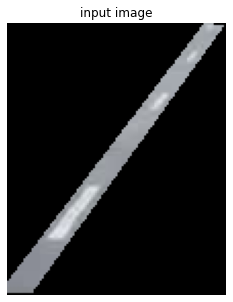

In [16]:
# Ensure that we are getting correct data from data loaders
batch_img, degradation_values = next(iter(train_loader))

print("Image batch shape:", batch_img.shape) 
print("Degradation label shape:", degradation_values.shape) 
print("Degradation target:", degradation_values[0])

sample_img = batch_img[0].numpy()   # (c, h, w)
sample_img = sample_img.transpose(1, 2, 0)

# sample_mask = batch_mask[0].numpy()   # (c, h, w)
# sample_mask = np.squeeze(sample_mask) # (h, w)

fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(sample_img)
ax.set_title("input image")
ax.axis("off")
plt.show()

In [17]:
# Initializing the model, loss function, and the optimizer
model_name = "cnn_sppf"
model = get_model(model_name, **model_config)
model = model.to(training.DEVICE)

## fetch loss function as set in config
criterion = get_loss(train_config["loss_fn_name"])

## OR add your own loss fucntion like shown below
# from model_suite.focal_loss import FocalLoss
# num_classes = 3
# alpha = [1.0, 1.2, 1.2]  # Example class weights
# criterion = FocalLoss(gamma=2, alpha=alpha, task_type='multi-class', num_classes=num_classes)

# initialized optimizer as required
optimizer = optim.Adam(model.parameters(), lr=train_config["learning_rate"])

checkpoint_path = train_config["resume_checkpoint"]
if checkpoint_path is not None:
    model.load_state_dict((torch.load(checkpoint_path, weights_only=True)))
    print("Model checkpoint loaded.")

In [18]:
# train the model
train_loop(model=model, loss_fn=criterion, optimizer=optimizer,
           train_loader=train_loader, val_loader=val_loader,
           num_epochs=train_config["num_epochs"], save_path=config["results_loc"],
           checkpoint_freq=train_config["save_checkpoint_freq"], save_prefix=model_name)

Training Started...


Epoch: 1 train - :   0%|          | 0/2000 [00:00<?, ?it/s]/home/default/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch: 1 val - : 100%|██████████| 1000/1000 [00:05<00:00, 195.16it/s]


Epoch [1/5], Train Loss: 0.0935, Val Loss: 0.0854, Epoch execution time: 0.65 min


Epoch: 2 val - : 100%|██████████| 1000/1000 [00:04<00:00, 216.35it/s]


Epoch [2/5], Train Loss: 0.0972, Val Loss: 0.0849, Epoch execution time: 0.51 min


Epoch: 3 val - : 100%|██████████| 1000/1000 [00:04<00:00, 224.01it/s]


Epoch [3/5], Train Loss: 0.0871, Val Loss: 0.0863, Epoch execution time: 0.54 min


Epoch: 4 val - : 100%|██████████| 1000/1000 [00:04<00:00, 204.76it/s]


Epoch [4/5], Train Loss: 0.0862, Val Loss: 0.0855, Epoch execution time: 0.51 min


Epoch: 5 val - : 100%|██████████| 1000/1000 [00:04<00:00, 203.93it/s]


Epoch [5/5], Train Loss: 0.0852, Val Loss: 0.0837, Epoch execution time: 0.53 min
   Learning curve saved to ../experiment_results/train_log/learning_curve_2025-04-16_07-03-04.png
   Learning history saved to ../experiment_results/train_log/learning_history_2025-04-16_07-03-04.json
Model saved at: ../experiment_results/checkpoints/cnn_sppf_final_2025-04-16_07-03-04.pth
Training Completed! Total time: 2.7386 min


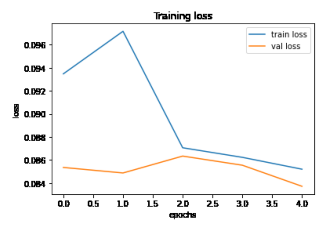

In [19]:
# open saved learning curve
plot_saved_path = "../experiment_results/train_log/learning_curve_2025-04-16_07-03-04.png"
img = load_image(plot_saved_path)
plt.imshow(img)
plt.axis("off")
plt.show()

In [20]:
# Evaluate model performance at end of training using different losses
train_metrics = cal_regression_metrics(model, train_loader, device=DEVICE)
val_metrics = cal_regression_metrics(model, val_loader, device=DEVICE)

100%|██████████| 1000/1000 [00:04<00:00, 247.74it/s]


In [21]:
print(f"Train Error: {train_metrics}")
print(f"Validation Error: {val_metrics}")

Train Error: {'MSE': 0.0833, 'MAE': 0.249, 'R2': 0.0226}
Validation Error: {'MSE': 0.0837, 'MAE': 0.2504, 'R2': 0.0273}


# Inference

In [22]:
saved_weight_path = "../experiment_results/checkpoints/cnn_sppf_final_2025-04-16_07-03-04.pth"

In [23]:
model_name = "cnn_sppf"
model_config = {'in_channels': 3, 'out_dim': 1}

In [24]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using DEVICE: {DEVICE}")

Using DEVICE: cuda


In [25]:
# initialize and load saved model
model = load_saved_model(model_name=model_name, saved_weight_path=saved_weight_path, **model_config)
model = model.to(DEVICE)

In [26]:
csv_path = dataset_config["val"]["degradation_csv"]
dir_path = dataset_config["val"]["img_dir"]
df = pd.read_csv(csv_path)

row = df.sample(1)
test_img_name, label = row["name"].values[0], row["degradation"].values[0]
test_img_path = os.path.join(dir_path, test_img_name)
test_img = load_image(test_img_path)

Test image name: b23adb0d-8a7aaced_2.png
Test image shape: (107, 178, 3)


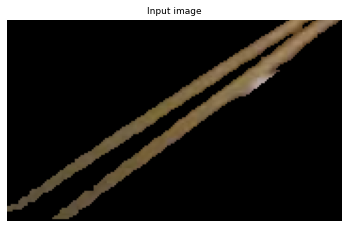

In [27]:
print("Test image name:", test_img_name)
print("Test image shape:", test_img.shape)
plt.imshow(test_img)
plt.axis("off")
plt.title("Input image", fontsize=9)
plt.show()

In [28]:
pred_value = pred_degradation_value(model=model, test_img=test_img, img_transform=None, add_batch_dim=True, device=DEVICE)
print("Predicticted degradation value:", pred_value)

Predicticted degradation value: 0.5132
